In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
import matplotlib.dates as mdates
from models import *
import math

In [8]:
font_style = {
  'size': 26,
  'weight': 'bold'
}
label_style = {
  'labelsize': 26,
  'labelweight': 'bold',
  'linewidth': 3
}
title_style = {
  'labelsize': 26,
  'labelweight': 'bold',
  'linewidth': 3
}
data_style = {'linewidth': 3}
legend_style = {
  'labelspacing': 0.3,
  'edgecolor':'none',
  'facecolor':'none',
  'fontsize':18,
  'loc': 'upper right'
}
plt.rc('font', **font_style)
plt.rc('axes', **label_style)
plt.rc('lines', **data_style)
plt.rc('legend', **legend_style)

def sliding_windows(x, y, seq_length):
    x_windows = []
    y_windows = []
    for i in range(seq_length, x.shape[0]):
        x_windows.append(x[i-seq_length:i, :])
        y_windows.append(y[i-seq_length:i+1])
    return np.array(x_windows), np.array(y_windows)

In [112]:
data = pd.read_csv('./assets/data.csv', index_col = "Date")
data['y'] = data['Close']

data_x = data.iloc[:, :-1].values
data_y = data.iloc[:, -1].values

train_x = data_x[:-330, :]
train_y = data_y[:-330]

print(f'train_x: {train_x.shape} train_y: {train_y.shape}')

x_scaler = RobustScaler()
y_scaler = RobustScaler()

train_x = x_scaler.fit_transform(train_x)
train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE([train_x.shape[1], 400, 400, 400, 400, 10], 10, use_cuda=1)
vae = vae.to(device)
num_epochs = 200
learning_rate = 0.0001
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)


train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float()),
                          batch_size=128, shuffle=True)


print('Training the VAE model------------------')
history = np.zeros(num_epochs)
for epoch in range(num_epochs):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, z, mu, log_var = vae(x)
        loss = vae.criterion(x_hat, x, mu, log_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    history[epoch] = total_loss
    print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}')

vae.eval()
with torch.no_grad():
    _, _, mu, _ = vae(torch.from_numpy(train_x).float().to(vae.device))
    mu = mu.cpu().numpy()

train_x = np.concatenate((train_x, mu), axis=1)

seq_length = 10
train_x, train_y = sliding_windows(train_x, train_y, seq_length)
print(f'train_x: {train_x.shape}, train_y: {train_y.shape}')


train_x: (2696, 57) train_y: (2696,)
Training the VAE model------------------
Epoch: 1/200, Loss: 471.7551
Epoch: 2/200, Loss: 418.2120
Epoch: 3/200, Loss: 383.1627
Epoch: 4/200, Loss: 361.6456
Epoch: 5/200, Loss: 344.3212
Epoch: 6/200, Loss: 322.2314
Epoch: 7/200, Loss: 300.0597
Epoch: 8/200, Loss: 281.6479
Epoch: 9/200, Loss: 247.0028
Epoch: 10/200, Loss: 226.8614
Epoch: 11/200, Loss: 199.3712
Epoch: 12/200, Loss: 194.0804
Epoch: 13/200, Loss: 166.0189
Epoch: 14/200, Loss: 147.9232
Epoch: 15/200, Loss: 147.4622
Epoch: 16/200, Loss: 121.6584
Epoch: 17/200, Loss: 108.2281
Epoch: 18/200, Loss: 110.9136
Epoch: 19/200, Loss: 101.8580
Epoch: 20/200, Loss: 77.3268
Epoch: 21/200, Loss: 72.4049
Epoch: 22/200, Loss: 91.9259
Epoch: 23/200, Loss: 86.8232
Epoch: 24/200, Loss: 59.9636
Epoch: 25/200, Loss: 54.2047
Epoch: 26/200, Loss: 68.1670
Epoch: 27/200, Loss: 78.4759
Epoch: 28/200, Loss: 70.4801
Epoch: 29/200, Loss: 58.4050
Epoch: 30/200, Loss: 48.3444
Epoch: 31/200, Loss: 39.4641
Epoch: 32/200

In [113]:
# Train the MHWGAN model and will fine-tune the model later
mhwgan = MHWGAN(67, 10, 1)
mhwgan.to(device)
init_epochs = 1000
learning_rate = 0.0000115
mhwgan_batch_size = 128
mhwgan.optimizers(lr=learning_rate)

# Use the whole dataset except testing data to train the model
mhwgan.mh_training(init_epochs, 0, 128, train_x, train_y, seq_length)

Training Basic for 1000 epochs
[1/1000] LossD: -0.00052 LossG: -0.19722
[2/1000] LossD: -0.00099 LossG: -0.20664
[3/1000] LossD: -0.00144 LossG: -0.21548
[4/1000] LossD: -0.00189 LossG: -0.22359
[5/1000] LossD: -0.00232 LossG: -0.23163
[6/1000] LossD: -0.00274 LossG: -0.23945
[7/1000] LossD: -0.00315 LossG: -0.24736
[8/1000] LossD: -0.00353 LossG: -0.25535
[9/1000] LossD: -0.00392 LossG: -0.26314
[10/1000] LossD: -0.00430 LossG: -0.27092
[11/1000] LossD: -0.00468 LossG: -0.27869
[12/1000] LossD: -0.00506 LossG: -0.28640
[13/1000] LossD: -0.00548 LossG: -0.29398
[14/1000] LossD: -0.00589 LossG: -0.30118
[15/1000] LossD: -0.00630 LossG: -0.30876
[16/1000] LossD: -0.00672 LossG: -0.31645
[17/1000] LossD: -0.00715 LossG: -0.32364
[18/1000] LossD: -0.00759 LossG: -0.33112
[19/1000] LossD: -0.00804 LossG: -0.33855
[20/1000] LossD: -0.00850 LossG: -0.34616
[21/1000] LossD: -0.00897 LossG: -0.35382
[22/1000] LossD: -0.00948 LossG: -0.36108
[23/1000] LossD: -0.00999 LossG: -0.36760
[24/1000] Lo

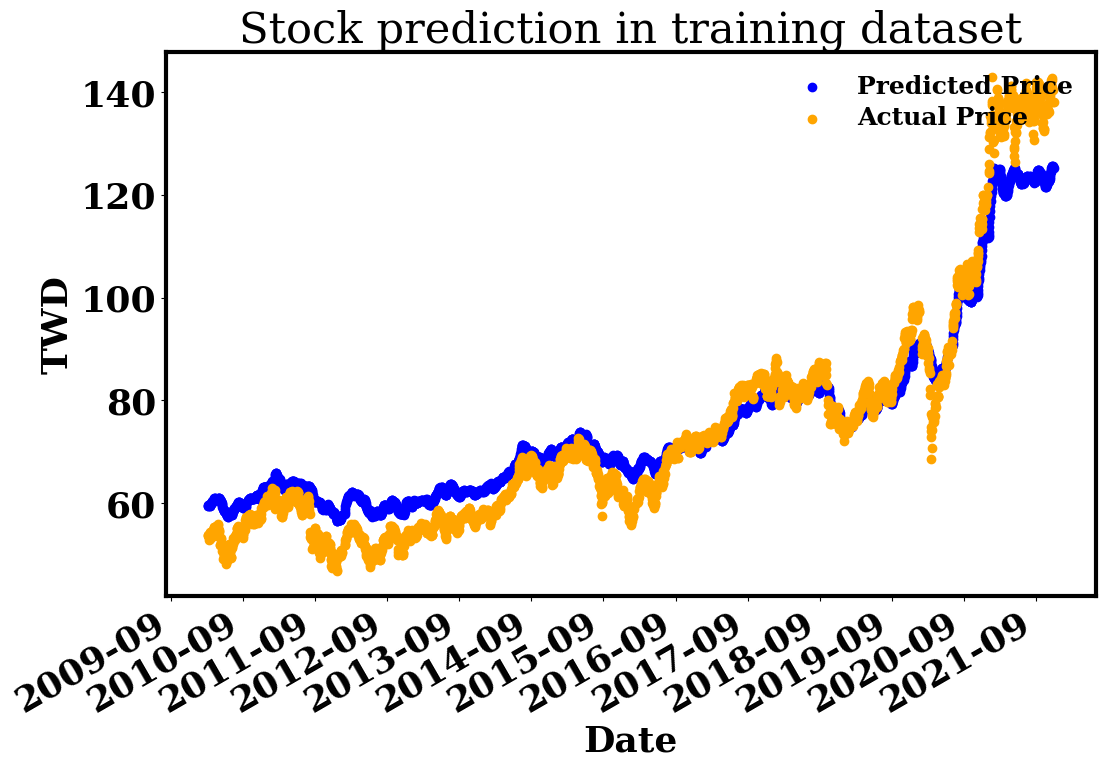

In [120]:
mhwgan.eval()
with torch.no_grad():
    pred_y = mhwgan(torch.from_numpy(train_x).float().to(mhwgan.device))

pred_y = pred_y.cpu().numpy()
pred_y = y_scaler.inverse_transform(pred_y.reshape(-1, 1))
inverse_test_y = y_scaler.inverse_transform(train_y[:, seq_length, :])
date = pd.to_datetime(data.iloc[10:-330, :].index)

fig, ax = plt.subplots(figsize=(12, 8))
scatter_pred = ax.scatter(date, pred_y, color='blue', label='Predicted Price')
scatter_actual = ax.scatter(date, inverse_test_y, color='orange', label='Actual Price')
ax.set_title('Stock prediction in training dataset')
ax.set_ylabel('TWD')
ax.set_xlabel('Date')
ax.legend(loc='upper right')

# Set the x-axis tick format to display three months interval
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

fig.autofmt_xdate()

In [131]:
# Fine-tune the MHWGAN model
train_x, test_x = data_x[:-330, :], data_x[-330:, :]
train_y, test_y = data_y[:-330], data_y[-330:]

train_x = x_scaler.transform(train_x)
train_y = y_scaler.transform(train_y.reshape(-1, 1))
test_x = x_scaler.transform(test_x)
test_y = y_scaler.transform(test_y.reshape(-1, 1))

print(f'train_x: {train_x.shape} train_y: {train_y.shape}')
print(f'test_x: {train_x.shape} test_y: {train_y.shape}')

vae.eval()
with torch.no_grad():
    _, _, mu_train_x, _ = vae(torch.from_numpy(train_x).float().to(vae.device))
    _, _, mu_test_x, _ = vae(torch.from_numpy(test_x).float().to(vae.device))
    mu_train_x = mu_train_x.cpu().numpy()
    mu_test_x = mu_test_x.cpu().numpy()

train_x = np.concatenate((train_x, mu_train_x), axis=1)
test_x = np.concatenate((test_x, mu_test_x), axis=1)

train_x, train_y = sliding_windows(train_x, train_y, seq_length)
test_x, test_y = sliding_windows(test_x, test_y, seq_length)
print(f'After concate latent variables')
print(f'train_x: {train_x.shape}, train_y: {train_y.shape}')
print(f'test_x: {train_x.shape} test_y: {train_y.shape}')

basic_epochs = 280
mh_epochs = 20
learning_rate = 0.000015
mhwgan_batch_size = 128
mhwgan.optimizers(lr=learning_rate)
mhwgan.mh_training(basic_epochs, mh_epochs, 128, train_x, train_y, seq_length)


train_x: (2696, 57) train_y: (2696, 1)
test_x: (2696, 57) test_y: (2696, 1)
After concate latent variables
train_x: (2686, 10, 67), train_y: (2686, 11, 1)
test_x: (2686, 10, 67) test_y: (2686, 11, 1)
Training Basic for 280 epochs
[1/280] LossD: -0.00975 LossG: 0.00816
[2/280] LossD: -0.01213 LossG: 0.00952
[3/280] LossD: -0.00924 LossG: 0.00734
[4/280] LossD: -0.00205 LossG: 0.00043
[5/280] LossD: 0.00072 LossG: 0.00093
[6/280] LossD: 0.00010 LossG: 0.00739
[7/280] LossD: -0.00067 LossG: 0.01403
[8/280] LossD: -0.00157 LossG: 0.01855
[9/280] LossD: -0.00193 LossG: 0.01840
[10/280] LossD: -0.00275 LossG: 0.01682
[11/280] LossD: -0.00375 LossG: 0.01350
[12/280] LossD: -0.00440 LossG: 0.00953
[13/280] LossD: -0.00412 LossG: 0.00797
[14/280] LossD: -0.00264 LossG: 0.00832
[15/280] LossD: -0.00105 LossG: 0.00763
[16/280] LossD: -0.00109 LossG: 0.00895
[17/280] LossD: -0.00219 LossG: 0.01080
[18/280] LossD: -0.00392 LossG: 0.00954
[19/280] LossD: -0.00590 LossG: 0.00685
[20/280] LossD: -0.00

RMSE : 2.8567034851443642
MAE : 2.1985332594604494


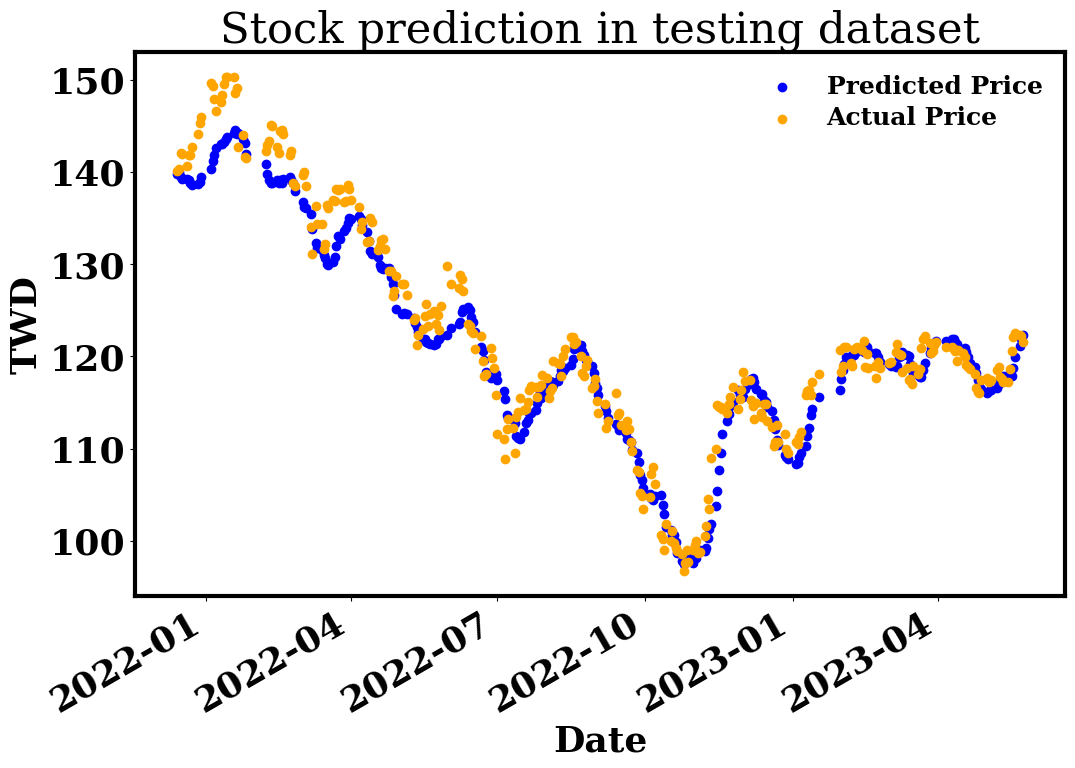

In [133]:
mhwgan.eval()
with torch.no_grad():
    pred_y = mhwgan(torch.from_numpy(test_x).float().to(mhwgan.device))

pred_y = pred_y.cpu().numpy()
pred_y = y_scaler.inverse_transform(pred_y.reshape(-1, 1))
inverse_test_y = y_scaler.inverse_transform(test_y[:, seq_length, :])
date = pd.to_datetime(data.iloc[-320:, :].index)

fig, ax = plt.subplots(figsize=(12, 8))
scatter_pred = ax.scatter(date, pred_y, color='blue', label='Predicted Price')
scatter_actual = ax.scatter(date, inverse_test_y, color='orange', label='Actual Price')
ax.set_title('Stock prediction in testing dataset')
ax.set_ylabel('TWD')
ax.set_xlabel('Date')
ax.legend(loc='upper right')

# Set the x-axis tick format to display three months interval
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

fig.autofmt_xdate()

MSE = mean_squared_error(inverse_test_y, pred_y)
RMSE = math.sqrt(MSE)
MAE = np.mean(np.abs(inverse_test_y - pred_y))
print(f'RMSE : {RMSE}')
print(f'MAE : {MAE}')